In [1]:
import numpy as np 
import matplotlib.pyplot as plt 

### Compute form factor of a spherical nano particle

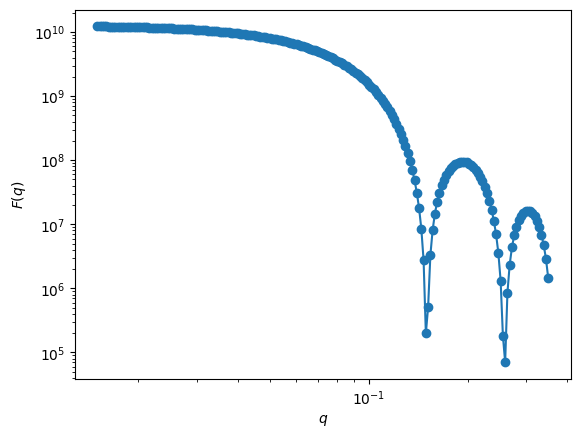

In [2]:
from scattersim.particles.sphere import Sphere 

pargs_sphere ={"radius" : 30.0,
               "rho_ambient" : 2.0,
               "rho_object" : 1.0
               }
sphere = Sphere(pargs_sphere)

q = np.geomspace(0.015, 0.35, 200)
sq_sphere = sphere.form_factor_squared_isotropic(q)

fig, ax = plt.subplots()
ax.loglog(q, sq_sphere, "-o")
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$F(q)$")
plt.show()

### Similarily, compute form factor of a polydisperse spherical nanoparticle

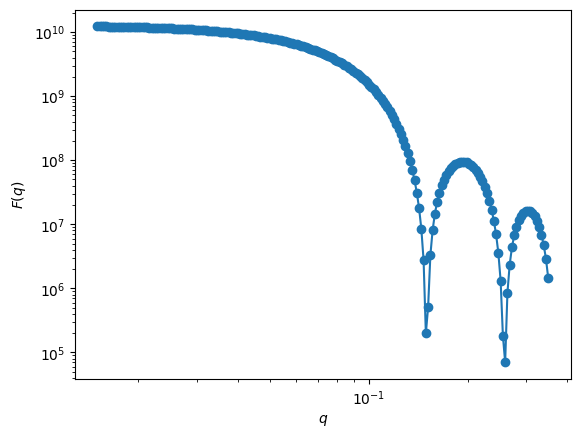

In [3]:
from scattersim.particles.base import PolydisperseNanoObject

pargs_polysphere ={"radius" : 30.0, 
                   "sigma_R" : 5.0,
                   "rho_ambient" : 2.0,
                   "rho_object" : 1.0
                   }
polysphere = PolydisperseNanoObject(Sphere, 
                                    pargs_polysphere,
                                    argname='radius', 
                                    argstdname='sigma_R'
                                    )
sq_polysphere = polysphere.form_factor_squared_isotropic(q)

fig, ax = plt.subplots()
ax.loglog(q, sq_polysphere, "-o")
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$F(q)$")
plt.show()

### Compare these form factors with sasmodels

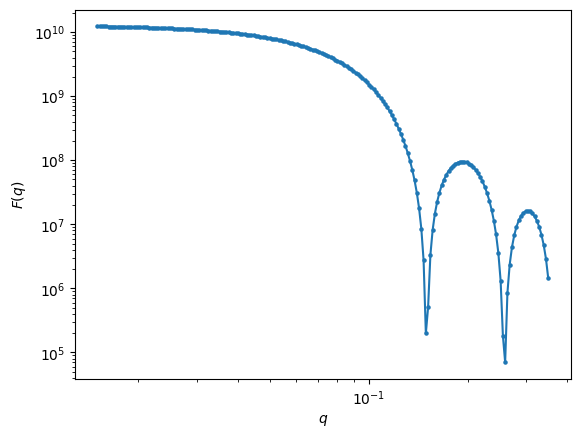

In [4]:
from sasmodels.core import load_model
from sasmodels.direct_model import call_kernel

model = load_model("sphere")
kernel = model.make_kernel([q*10])
sphere_params = {"radius":3.0,
                 "radius_pd":0.8,
                 "sld" : 1e6,
                 "sld_solvent" : 2e6,
                 "background" : 0.0
                 }
Iq_sasmodels = call_kernel(kernel, sphere_params)*(polysphere.volume()*1e-3)*0.01

fig, ax = plt.subplots()
ax.loglog(q, Iq_sasmodels)
ax.scatter(q, sq_polysphere, s=5)
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$F(q)$")
plt.show()

### Place the nanoparticle in a simple cubic lattice and compute SAXS

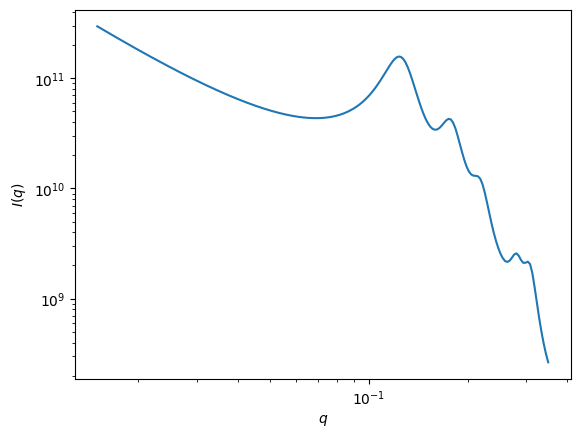

In [5]:
from scattersim.lattices.simple_cubic import SimpleCubic
from scattersim.utils import PeakShape

lattice_spacing = 50.0
sigma_D = 0.06 # add a Debye-Waller factor
lattice = SimpleCubic([polysphere], 
                     lattice_spacing_a=lattice_spacing, 
                     sigma_D=sigma_D
                     )
peak = PeakShape(delta=0.03, nu=0.01) 

Z0_sc = lattice.intensity(q, peak)
Pq_sc = lattice.form_factor_squared_isotropic(q)

c_sc = .1
Gq_sc = lattice.G_q(q)

Sq_sc = c_sc*Z0_sc/Pq_sc*Gq_sc + (1-Gq_sc) # assuming beta(q) = 1
Iq_sc = Pq_sc*Sq_sc 

fig, ax = plt.subplots()
ax.loglog(q, Iq_sc)
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$I(q)$")
plt.show()

### Add vacancy disorder

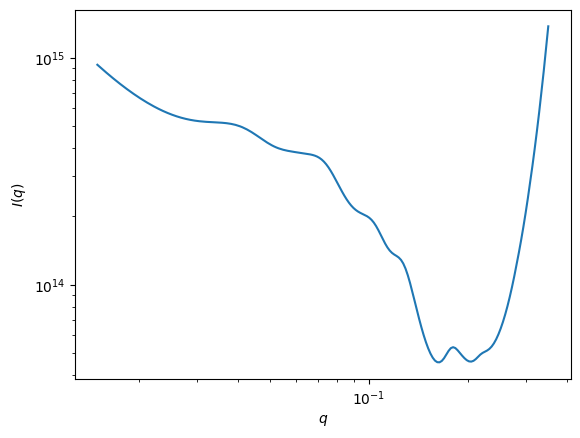

In [6]:
from scattersim.lattices.simple_cubic import RandomizedSimpleCubic
from scattersim.utils import PeakShape

lattice_spacing = 50.0 
sigma_D = 0.06 # add a Debye-Waller factor
lattice = RandomizedSimpleCubic([polysphere], 
                                lattice_spacing_a=lattice_spacing, 
                                sigma_D=sigma_D,
                                filling_probs = [0.5]
                                )
peak = PeakShape(delta=0.03, nu=0.01) 

Z0_vac_sc = lattice.intensity(q, peak)
Pq_vac_sc = lattice.form_factor_squared_isotropic(q)

c = .1
Gq = lattice.G_q(q)

Sq_vac_sc = (c*Z0_vac_sc)/(Pq_vac_sc*Gq) + (1-Gq) # assuming beta(q) = 1
Iq_vac_sc = Pq_vac_sc*Sq_vac_sc 

fig, ax = plt.subplots()
ax.loglog(q, Iq_vac_sc)
ax.set_xlabel(r"$q$")
ax.set_ylabel(r"$I(q)$")
plt.show()